In [1]:
library(mgcv)
library(tidyverse)
library(lubridate)
library(glue)

fig <- function(width, heigth){
    # borrowed from https://www.kaggle.com/getting-started/105201
    options(repr.plot.width = width, repr.plot.height = heigth)
}
set.seed(42)

Loading required package: nlme

This is mgcv 1.8-35. For overview type 'help("mgcv-package")'.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse() masks nlme::collapse()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


The following object is masked from ‘package:nlme’:

    collapse




# Turtles all the way down

I'm using the output of Mehran Kazeminia & Somayyeh Gholami's *very* high scoring [TPS Jul 21 - Smart Ensembling](https://www.kaggle.com/mehrankazeminia/2-tps-jul-21-smart-ensembling) to predict "target_nitrogen_oxides" as a regression problem.

This is almost certainly no better than the original script +- some noise. Using pseudolabelling on top of pseudolabelling doesn't sound good for one's health. 

Why on earth do this? I'm interested in exploring the trend and interactions as they relate to nitrogen_oxides, and if there is any information left on the table by not using the correlations between the other predictors and nitogen oxides.

I really would advise against submitting this!

In [2]:
# Read Data
df_train <- read_csv("../input/tabular-playground-series-jul-2021/train.csv", col_types = cols())
df_test  <- read_csv("../input/tabular-playground-series-jul-2021/test.csv",  col_types = cols())
df_preds <- read_csv("../input/2-tps-jul-21-smart-ensembling/submission.csv", col_types = cols())


## Add predictions from the ensemble submission
df_test <- df_test %>% inner_join(df_preds)

## add features
df_all <- bind_rows(
    df_train %>% mutate(row_type = 'train'), 
    df_test  %>% mutate(row_type = 'test')) %>%
    rename_all(str_to_lower) %>%
    mutate(
        no_sensor = (sensor_4 < 646 & absolute_humidity < 0.238),
        hour = hour(date_time),
        wday = wday(date_time, label = FALSE),
        # we are using regression only, so this is allowed
        trend = as.numeric((as.Date(date_time) - ymd('2010-03-10')), "days"),
        month = month(date_time, label = FALSE))

Joining, by = "date_time"



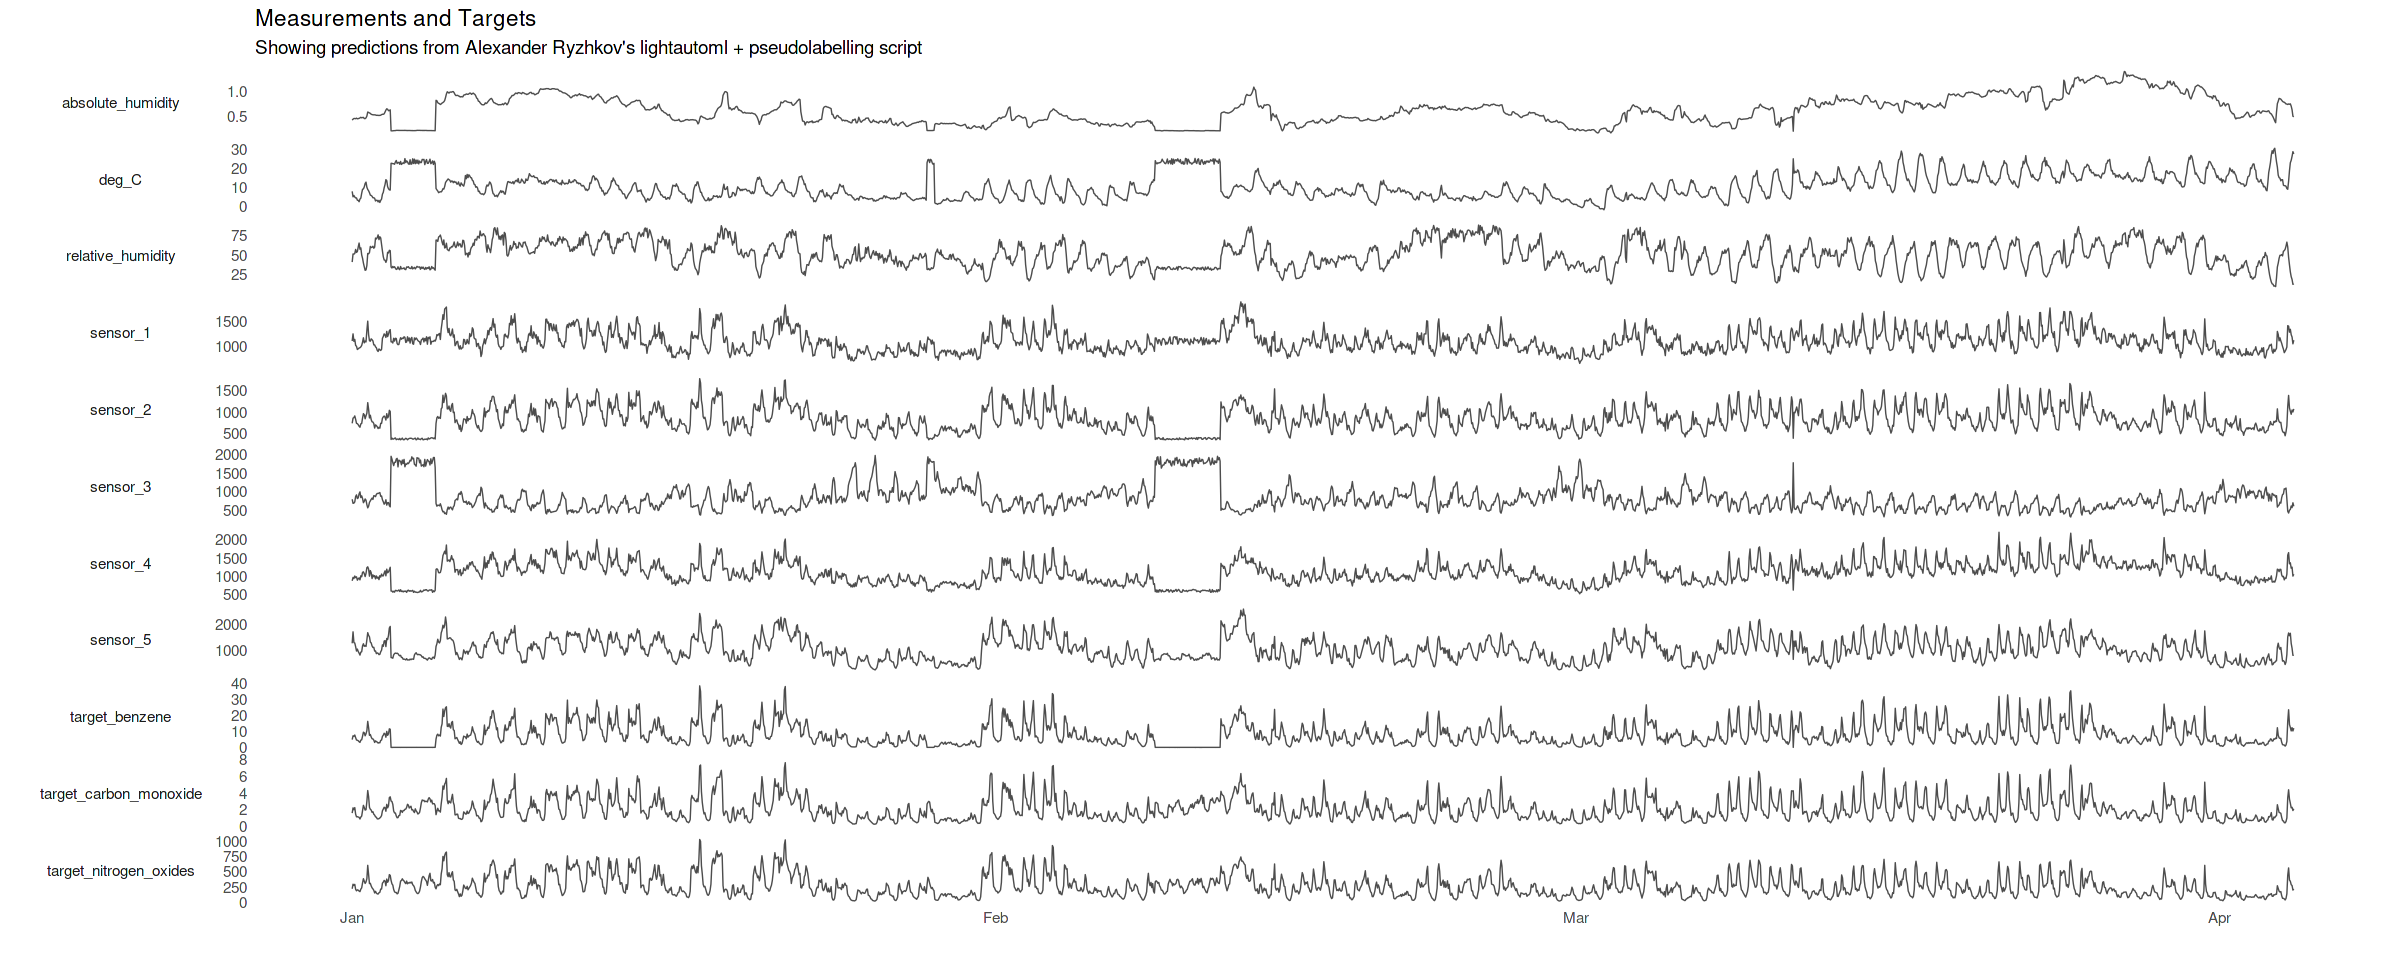

In [3]:
fig(20,8)
g <- bind_rows(df_test) %>% 
    pivot_longer(-date_time, names_to = "observation", values_to = "value") %>%
    ggplot(mapping = aes(x = date_time, y = value)) +
        theme_minimal() +
        geom_line(size = 0.3, alpha = 0.7) +
        facet_grid(observation ~ ., scales = "free_y", switch = "y") +
        theme(strip.text.y.left = element_text(angle = 0)) +
        theme(strip.placement = "outside") +
        theme(panel.grid = element_blank(), legend.position = "None") +
        labs(
            x = "", y = "", 
            title = "Measurements and Targets", 
            subtitle = "Showing predictions from Alexander Ryzhkov's lightautoml + pseudolabelling script")

suppressWarnings(print(g))


Family: Scaled t(3.311,0.106) 
Link function: identity 

Formula:
log(target_nitrogen_oxides) ~ s(sensor_1, k = 30) + s(sensor_2, 
    k = 30) + s(sensor_3, k = 30) + s(sensor_4, k = 30) + s(sensor_5, 
    k = 30) + s(deg_c, k = 30) + s(relative_humidity, k = 30) + 
    s(absolute_humidity, k = 30) + s(hour, k = 24, bs = "cc") + 
    s(wday, k = 7, bs = "cc") + ti(relative_humidity, absolute_humidity) + 
    ti(hour, wday, bs = "cc", k = c(24, 7)) + s(trend, k = 250) + 
    s(target_benzene) + s(target_carbon_monoxide) + ti(sensor_2, 
    sensor_5) + ti(target_benzene, target_carbon_monoxide)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.4030     0.0361   149.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                              edf Ref.df      F p-value    
s(sensor_1)                                 7.376     29  2.783  <2e-16 ***
s(sen

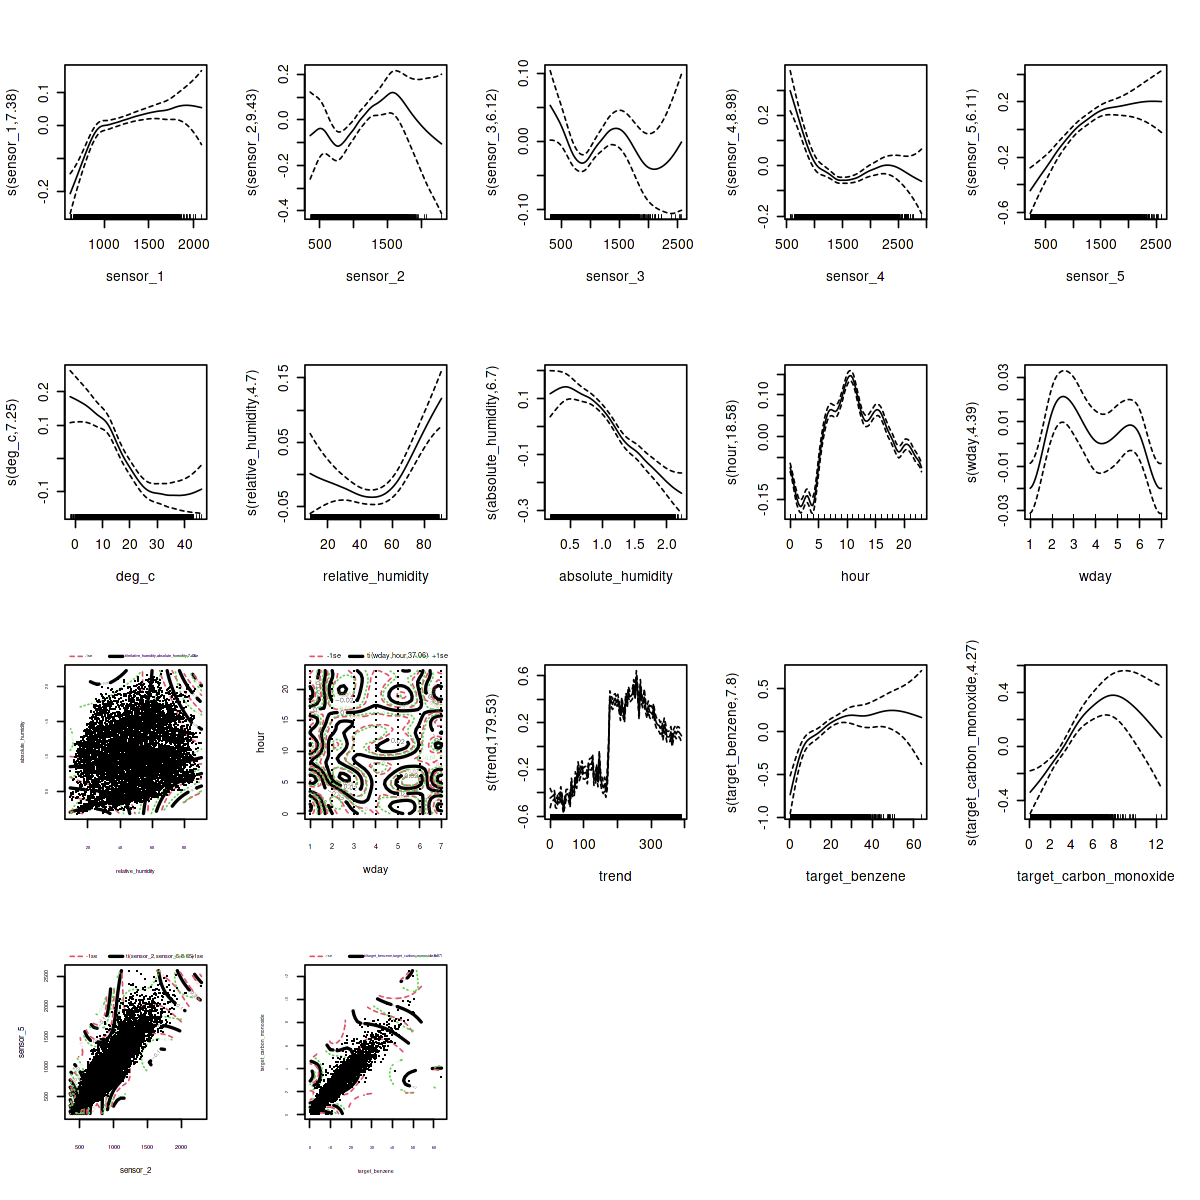

In [4]:
train_data <- bind_rows(
    # all of train, and test
    df_all %>% filter(row_type == 'train' & !no_sensor),
    df_all %>% filter(row_type == 'test'  & !no_sensor)) %>%
    mutate(
        # truthiness - less trust for the pseudo labels :)
        weight = ifelse(row_type == 'train', 1, 0.7)
    )

gam_formula <-  log(target_nitrogen_oxides) ~ 
    s(sensor_1, k=30) + 
    s(sensor_2, k=30) + 
    s(sensor_3, k=30) +
    s(sensor_4, k=30) + 
    s(sensor_5, k=30) +
    s(deg_c, k=30) + s(relative_humidity, k=30) + s(absolute_humidity, k=30) +
    s(hour, k = 24, bs = "cc") + 
    s(wday, k = 7, bs = "cc") + 
    # interactions
    ti(relative_humidity , absolute_humidity) +
    ti(hour, wday, bs = 'cc', k=c(24, 7)) +
    s(trend, k=250) +
    s(target_benzene) +
    s(target_carbon_monoxide) +
    ti(sensor_2, sensor_5) +
    ti(target_benzene, target_carbon_monoxide)

fit <- mgcv::bam(
    formula = gam_formula, 
    family = scat(link="identity"), # heavy tails... scaled t-
    discrete = TRUE,
    select = TRUE,
    samfrac = 0.05,
    nthreads = 4, 
    gamma = 1.2,
    weights = train_data$weight,
    data = train_data)

fig(10, 10)
print(summary(fit))
plot(fit, pages=1, scale=0)

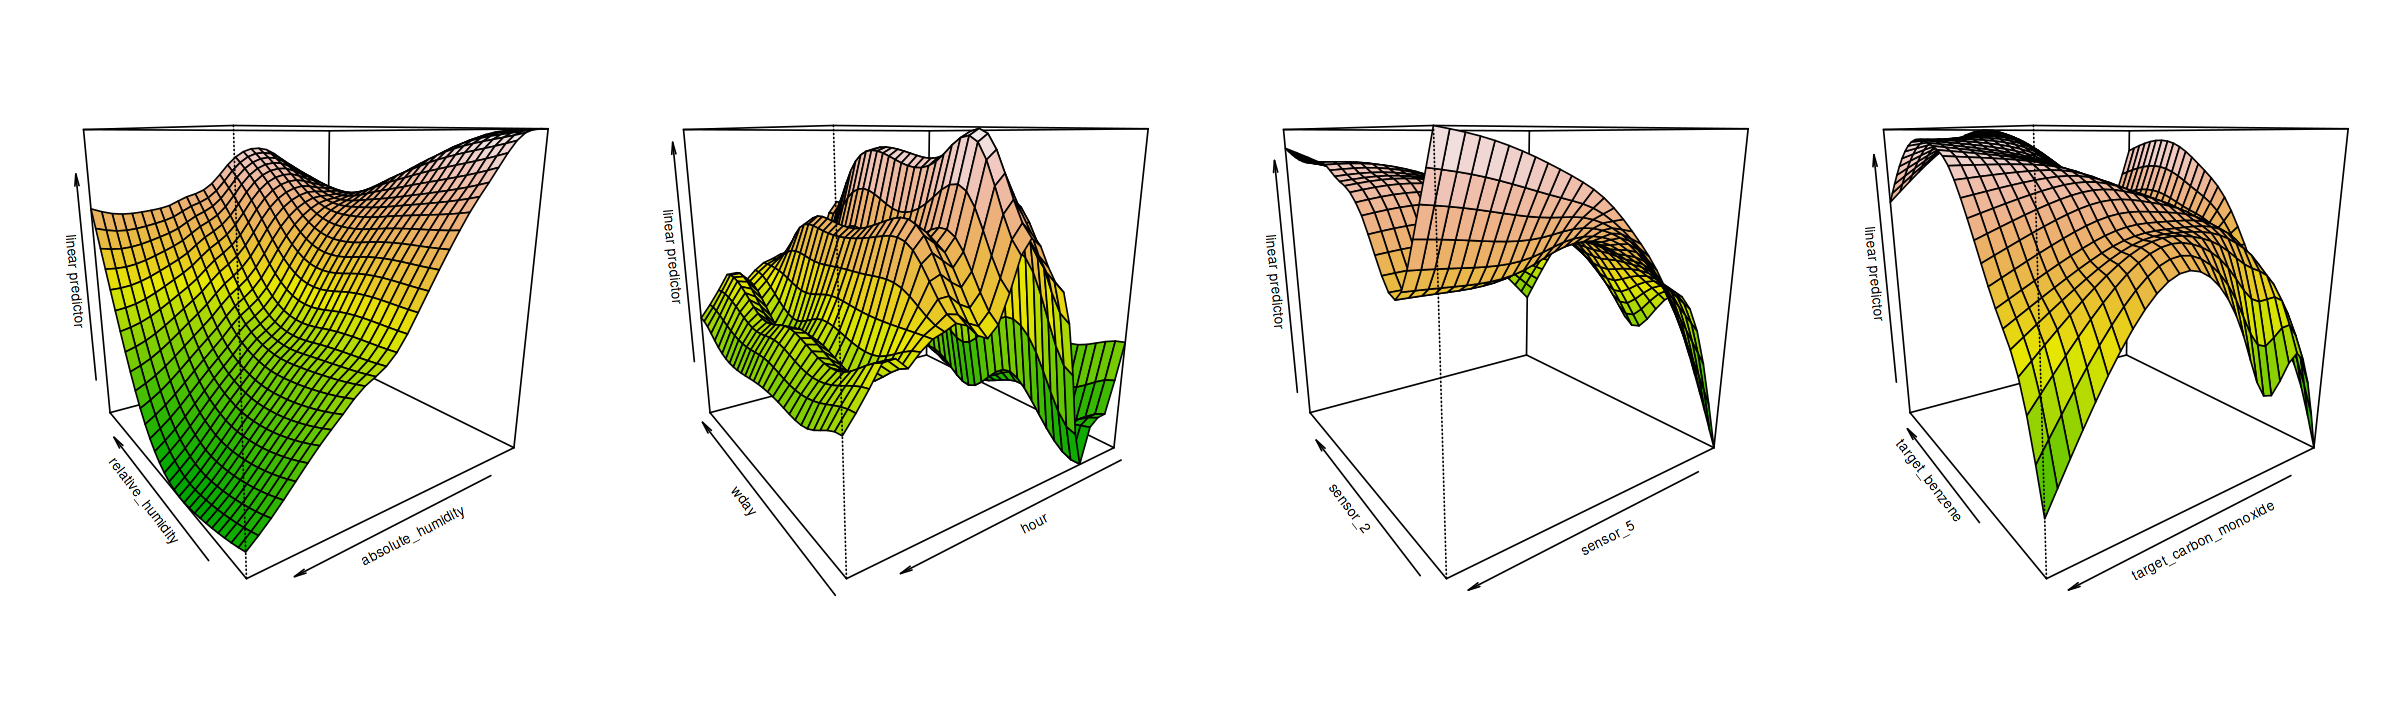

In [5]:
# let's have a look at the interactions
fig(20,6)
par(mfrow = c(1, 4))
vis.gam(fit, view=c("relative_humidity","absolute_humidity"), 
    color = 'terrain', theta = -125)
vis.gam(fit, view=c("wday","hour"), 
    color = "terrain", theta = -125)
vis.gam(fit, view=c("sensor_2","sensor_5"), 
    color = "terrain", theta = -125)
vis.gam(fit, view=c("target_benzene","target_carbon_monoxide"), 
    color = "terrain", theta = -125)


Method: fREML   Optimizer: perf chol
$grad
 [1]  9.228656e-09  9.412021e-09  7.811796e-11 -5.519355e-05  6.777702e-09
 [6] -3.987339e-05 -1.096628e-08 -2.904420e-09 -1.152166e-08 -1.070856e-08
[11]  2.005482e-08 -7.624335e-05  4.482806e-08 -5.871473e-10 -3.154086e-08
[16] -4.380334e-05  1.681217e-07  4.920887e-08 -1.348270e-08 -3.579268e-08
[21] -1.002826e-08  6.594204e-08  6.678000e-09 -1.267247e-06 -1.072015e-05
[26] -6.985987e-08 -5.925717e-09  1.068116e-08  1.344285e-05 -2.165756e-11
[31]  2.473083e-08 -5.122771e-05 -6.312337e-08 -2.120459e-08 -1.388284e-06

$hess
               [,1]          [,2]          [,3]          [,4]          [,5]
 [1,]  2.466531e+00  7.646870e-03  1.147719e-02 -1.668362e-07 -1.348509e-02
 [2,]  7.646870e-03  2.906096e-01  1.469793e-02  7.603307e-08 -2.485591e-04
 [3,]  1.147719e-02  1.469793e-02  1.784801e+00 -3.925887e-05 -2.553007e-02
 [4,] -1.668362e-07  7.603307e-08 -3.925887e-05  5.518746e-05 -3.864943e-08
 [5,] -1.348509e-02 -2.485591e-04 -2.553007e

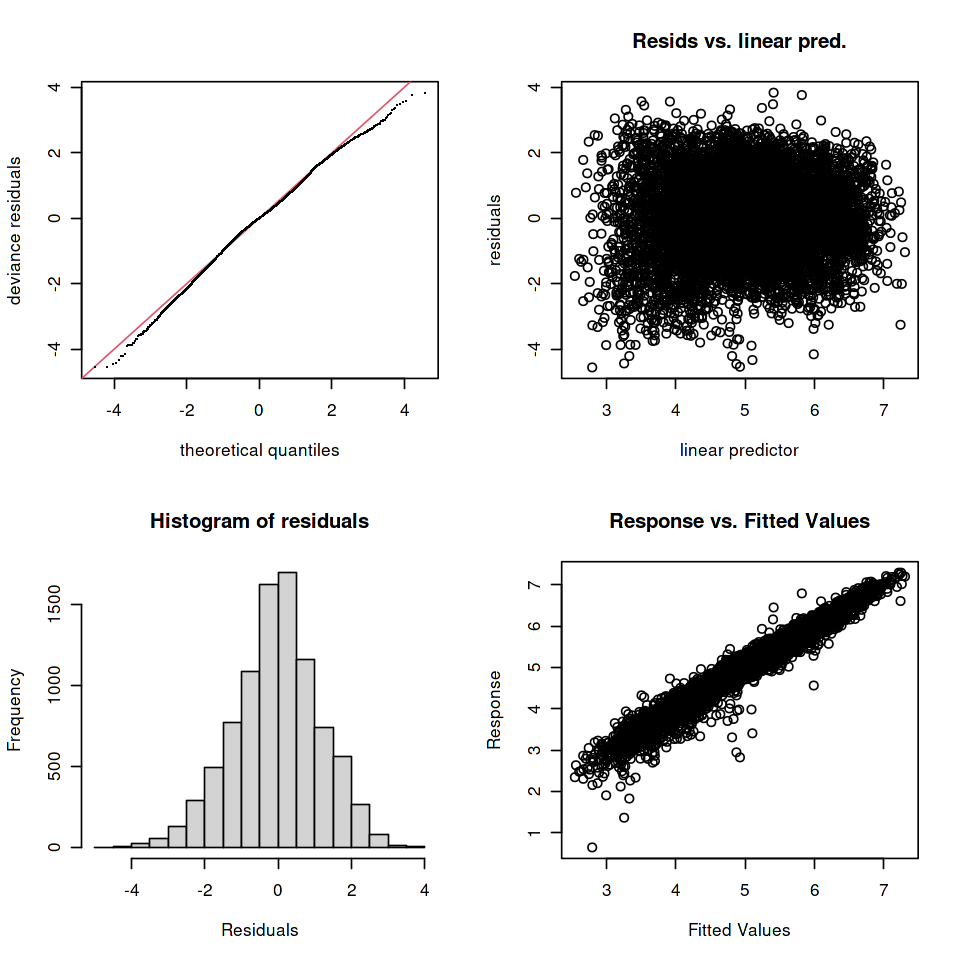

In [6]:
fig(8,8)
gam.check(fit)

In [7]:
# Overwrite original predictions (where we have sensor readings)
df_pred <- df_all %>%
    filter(
        row_type == "test")

df_pred <- df_pred %>% 
    mutate(
        target_nitrogen_oxides_original = target_nitrogen_oxides,
        target_nitrogen_oxides  = ifelse(
            no_sensor, 
            target_nitrogen_oxides, 
            exp(predict(fit, newdata = df_pred, type = "response"))) 
    )

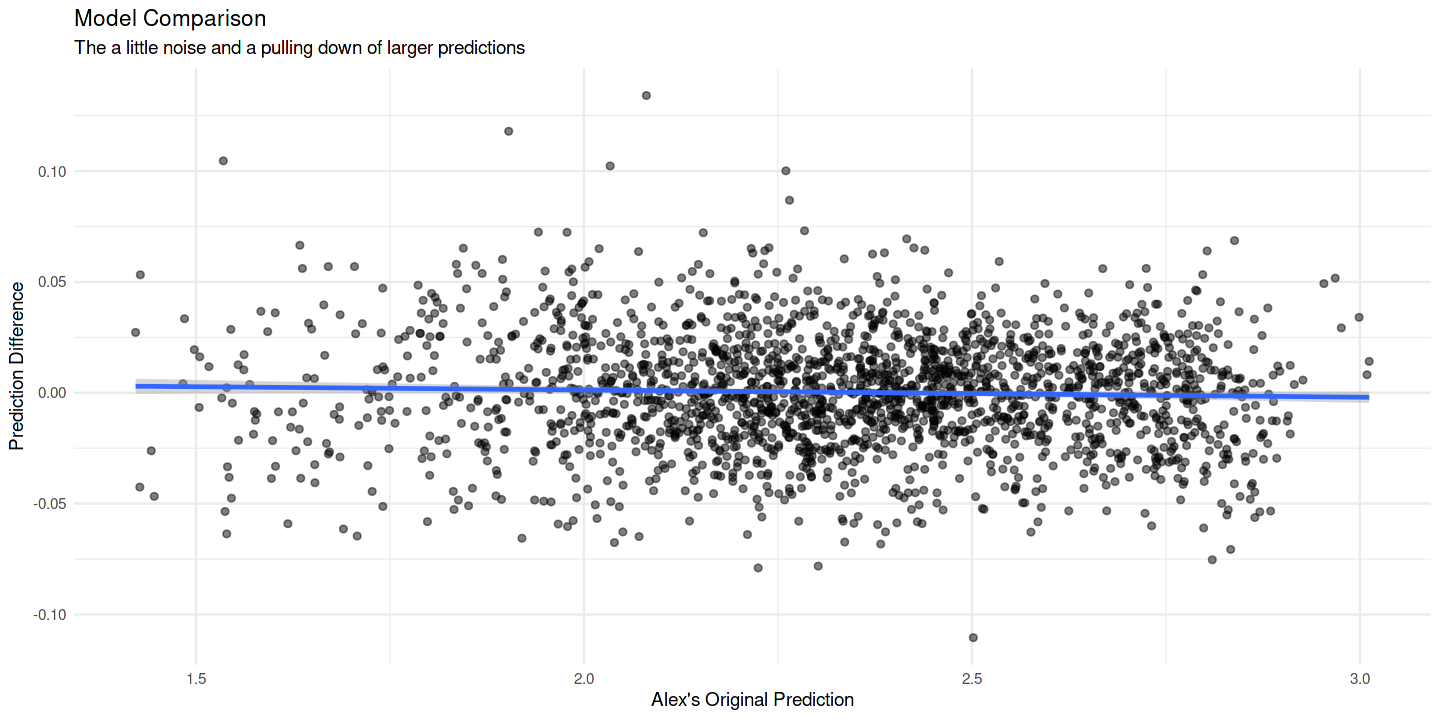

In [8]:
fig(12,6)
df_pred %>%
    filter(!no_sensor) %>%
    ggplot(df_pred,
        mapping = aes(
            x = log10(target_nitrogen_oxides_original), 
            y = log10(target_nitrogen_oxides_original) - log10(target_nitrogen_oxides))) +
        theme_minimal() +
        geom_point(alpha = 0.5) +
        geom_smooth(method = 'gam', formula = y ~ s(x, bs = "cs")) +
        labs(
            title = "Model Comparison",
            subtitle = "The a little noise and a pulling down of larger predictions",
            y = "Prediction Difference",
            x = "Alex's Original Prediction"
        )

In [9]:
df_pred %>% 
    select(date_time, target_carbon_monoxide, target_benzene, target_nitrogen_oxides) %>%
    mutate(
        date_time = strftime(date_time, '%Y-%m-%d %H:%M:%S')) %>%
    write_csv("submission_gam_adjust.csv")